In [11]:

import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

In [12]:
# Loading dataset
mat=loadmat('ex8data1.mat')
X=mat['X']
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
Xval
yval


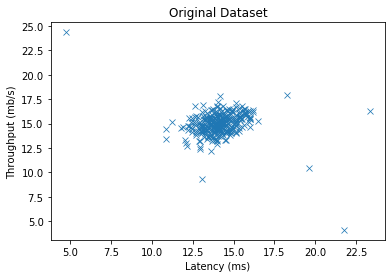

In [13]:
fig=sns.scatterplot(X[:,0],X[:,1],marker='x')
fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title='Original Dataset');

In [14]:
def mutlivariateGaussian(X,mu,sigma):
    p=(1/(np.sqrt(2*np.pi*np.power(sigma,2))))*np.exp(-np.power(X-mu,2)/(2*np.power(sigma,2)))
    p=np.product(p,axis=1).reshape((-1,1))
    return p

In [15]:
def estimateGaussian(X):
    mu=np.mean(X,axis=0)
    sigma=np.std(X,axis=0)
    return (mu,sigma)

In [16]:

def plotGaussianContour(X,mu,sigma,title=None):
    # Constructing grid around the min and max range of original data
    temp=np.linspace(np.min(X)-5,np.max(X)+5)
    [x1,x2]=np.meshgrid(temp,temp)
    # Computing the Gaussian Density Probability for the grid
    temp=np.array([x1.reshape(-1),x2.reshape(-1)]).T
    z=mutlivariateGaussian(temp,mu,sigma).reshape(x1.shape)
    # Plotting
    levels=np.power(10,list(map(lambda x:float(x),list(range(-20,0,3)))))
    plt.contour(x1,x2,z,levels=levels);
    fig=sns.scatterplot(X[:,0],X[:,1],marker='x')
    title='Gaussian Distribution Contours' if title==None else title
    fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title=title);

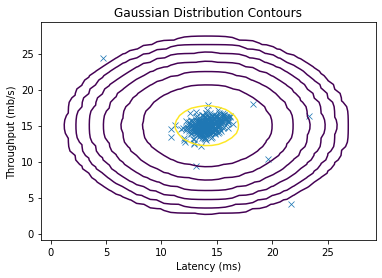

In [17]:
# Estimating Gaussian parameters
mu,sigma=estimateGaussian(X)
# Computing Density Probability
p=mutlivariateGaussian(X,mu,sigma)
# Plotting
plotGaussianContour(X,mu,sigma);

In [18]:
Xval=mat['Xval']
yval=mat['yval']

In [19]:
def selectThreshold(yval,pval):
    '''
     Returns the threshold value of epsilon and the corresponding F1 score.
    '''
    bestEpsilon=bestF1=F1=0
    epsilons=np.linspace(np.min(pval),np.max(pval),1000)
    for epsilon in epsilons:
        cvPrediction=pval<epsilon
        tp=np.sum((cvPrediction==1) & (yval==1))
        fp=np.sum((cvPrediction==1) & (yval==0))
        fn=np.sum((cvPrediction==0) & (yval==1))
        prec=rec=0
        # Computing Precision
        if tp+fp>0:
            prec=tp/(tp+fp)
        # Computing Recall
        if tp+fn>0:
            rec=tp/(tp+fn)
        # Computing F1 Score
        if prec+rec>0:
            F1=(2*prec*rec)/(prec+rec)
        if F1>bestF1:
            bestF1=F1
            bestEpsilon=epsilon
    return (bestEpsilon,bestF1)

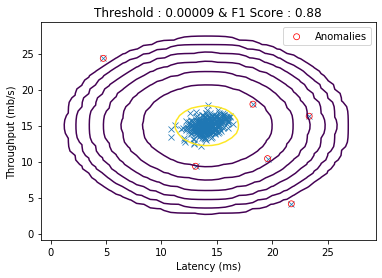

In [20]:

# Using sample mean and std. to compute density probability for cross validation set
pval=mutlivariateGaussian(Xval,mu,sigma)
# Calculating the threshold based on the best F1 Score
epsilon,f1=selectThreshold(yval,pval)
# Getting indices for anomalous examples
indices=np.where((p<epsilon)==True)[0]
# Plotting anomalies
title=f'Threshold : {epsilon:.5f} & F1 Score : {f1:.2f}'
plotGaussianContour(X,mu,sigma,title=title)
sns.scatterplot(X[indices,0],X[indices,1],marker='o',facecolors='none',edgecolor='r',label='Anomalies');

In [21]:
# Loading dataset
mat=loadmat('ex8data2.mat')
X=mat['X']
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
Xval
yval


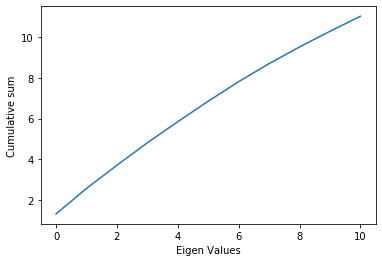

In [22]:
# Centering and scaling the data matrix
xPCA=(X-X.mean(axis=0))/X.std(axis=0)
# Computing Covariance
C=np.cov(xPCA.T)
# Computing eigenvalues and eigenvectors
eigenValues,eigenVectors=np.linalg.eig(C)
# Sorting eigenvalues in descending order
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[idx]

# Plotting elbow curve
chart=sns.lineplot(list(range(len(eigenValues))),np.cumsum(eigenValues));
chart.set(xlabel='Eigen Values',ylabel='Cumulative sum');

In [23]:
# Computing Gaussian Parameters
mu,sigma=estimateGaussian(X)
p=mutlivariateGaussian(X,mu,sigma)

In [24]:
# Using Cross Validation set to select a threshold
Xval=mat['Xval']
yval=mat['yval']
# Computing density probability
pval=mutlivariateGaussian(Xval,mu,sigma)
epsilon,f1=selectThreshold(yval,pval)
print(f'Epsilon : {epsilon}')
print(f'F1 Score : {f1}')

Epsilon : 1.3786074982000233e-18
F1 Score : 0.6153846153846154


In [25]:

indices=np.where((p<epsilon)==True)[0]
pd.DataFrame(X[indices])

,0,1,2,3,4,5,6,7,8,9,10
0,15.107877,-16.430766,19.707360,-19.811888,-1.644537,-6.444184,-6.121214,7.042283,7.232476,17.223479,-2.956852
1,12.411706,3.150959,14.827734,-10.482672,-8.250082,-7.982698,-20.766918,30.689476,4.622547,12.234751,23.167294
2,20.946754,1.048170,8.296324,-2.595042,-14.061970,8.776611,-21.886068,9.769264,-20.071130,13.871906,4.197881
3,5.127033,-18.517137,11.422480,-28.993408,-5.797960,-15.989215,-12.039753,31.296681,8.203208,8.035668,19.519680
4,11.622006,-0.229723,10.005823,-9.700729,-14.765493,26.933578,-9.299882,13.109171,8.976218,8.157170,18.663064
...,...,...,...,...,...,...,...,...,...,...,...
112,-7.514689,-11.633082,12.714199,-9.659930,-20.170026,46.574569,-10.498804,20.522685,-1.223742,4.478910,-0.186369
113,8.610956,-2.087595,13.609762,-5.509457,4.565548,-2.150133,6.652794,6.604923,-0.554557,-21.551409,5.522046
114,4.712890,-5.468014,7.463785,15.156009,-4.815854,-10.092629,3.830391,-0.360002,-11.221351,-3.262486,1.591322
115,-12.120077,-5.845913,28.951978,-10.215184,-18.070297,15.439734,-4.961338,31.429439,-7.406423,5.847000,20.797016


In [26]:

def costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda):
    # Unrolling Parameters
    Y=Y[:numMovies,:numUsers]
    R=R[:numMovies,:numUsers]
    params=params.reshape(-1)
    X=params[:numMovies*numFeatures].reshape((numMovies,numFeatures))
    theta=params[numMovies*numFeatures:].reshape((numUsers,numFeatures))
    # Computing Cost
    H=np.dot(X,theta.T)
    J=(1/2)*np.power(np.multiply(R,H-Y),2).sum()
    Jreg=(lmbda/2)*(np.power(X,2).sum()+np.power(theta,2).sum())
    J=J+Jreg
    # Computing Gradient
    xGrad=np.dot(np.multiply(R,H-Y),theta)+lmbda*X
    thetaGrad=np.dot(np.multiply(R,H-Y).T,X)+lmbda*theta
    # Rolling into one variable
    params=np.row_stack((xGrad.reshape((-1,1)),thetaGrad.reshape((-1,1))))
    return (J,params)

In [27]:
def regularizedGradientDescent(initialParams,Y,R,numUsers,numMovies,numFeatures,lmbda,alpha,iterations):
    jHistory=[]
    params=initialParams
    print('Training Collaborative Filtering...')
    for i in range(iterations):
        # Computing cost
        J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
        jHistory.append(J)
        print(f'ITERATIONS : {i+1}\t\tCOST : {J:.3f}',end='\r')
        # Parameters update rule
        params=params-alpha*grad
    df=pd.DataFrame({'Iterations':range(iterations),'Cost Function':jHistory})
    sns.lineplot(data=df,x='Iterations',y='Cost Function');
    return jHistory,params

In [28]:
def computeNumericalGradient(J,theta):
    '''Computes the numerical gradient using two point slope equation'''
    numGrad=np.zeros(theta.shape)
    perturb=np.zeros(theta.shape)
    epsilon=1e-4
    for i in range(theta.size):
        perturb[i,:]=epsilon
        numGrad[i,:]=(J(theta+perturb)-J(theta-perturb))/(2*epsilon)
        perturb[i,:]=0
    return numGrad

def checkNNGradients(lmbda):
    # Create small problem
    X=np.random.randn(4,3)
    theta=np.random.randn(5,3)   
    Y=np.dot(X,theta.T)
    Y[np.random.rand(*Y.shape)>0.5]=0
    R=np.zeros(Y.shape)
    R[Y!=0]=1
    numUsers=Y.shape[1]
    numMovies=Y.shape[0]
    numFeatures=theta.shape[1]
    # Gradient from cost function derivative
    params=np.row_stack((X.reshape((-1,1)),theta.reshape((-1,1))))
    J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
    # Computing numerical gradient
    def cost(params):
        J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
        return J
    numGrad=computeNumericalGradient(cost,params)
    # Evaluating the norm of the differences between two solution
    diff=np.linalg.norm(numGrad-grad)/np.linalg.norm(numGrad+grad)
    return grad,numGrad,diff        

lmbda=1.5
grad,numGrad,diff=checkNNGradients(lmbda)
print(f'DIFFERENCE : {diff}')
pd.DataFrame(data={'grad (derivative)':grad.reshape(-1),'grad (numerical)':numGrad.reshape(-1)})

DIFFERENCE : 4.747765193699018e-12


,grad (derivative),grad (numerical)
0,1.701119,1.701119
1,0.290588,0.290588
2,1.207009,1.207009
3,1.196246,1.196246
4,-0.652741,-0.652741
5,0.035062,0.035062
6,3.558965,3.558965
7,0.133666,0.133666
8,1.589794,1.589794
9,2.374954,2.374954


In [29]:
# Loading data
mat=loadmat('ex8_movies.mat')
Y=mat['Y']
R=mat['R']

numUsers=Y.shape[1]
numMovies=Y.shape[0]
numFeatures=10

print("Y : {0} X {1}".format(*Y.shape))
print("R : {0} X {1}".format(*R.shape))

Y : 1682 X 943
R : 1682 X 943


In [30]:
# Loading Movies
movies={'ID':[],'Movie':[],'Year':[]}
with open('movie_ids.txt') as f:
    for line in f.readlines():
        movies['ID'].append(int(line.split()[0]))
        movies['Movie'].append(' '.join(line.split()[1:-1]))
        movies['Year'].append(line.split()[-1][1:-1])
movies=pd.DataFrame(movies)
movies=movies.set_index('ID')
movies.sample(10)


,Movie,Year
ID,,
988,"Beautician and the Beast, The",1997
408,"Close Shave, A",1995
1246,Bushwhacked,1995
574,Boxing Helena,1993
984,Shadow Conspiracy,1997
345,Deconstructing Harry,1997
426,"Transformers: The Movie, The",1986
929,Harriet the Spy,1996
653,Touch of Evil,1958


In [31]:
pd.DataFrame(Y,movies['Movie']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
Movie,,,,,,,,,,,,,,,,,,,,,
Toy Story,5,4,0,0,4,4,0,0,0,4,...,2,3,4,0,4,0,0,5,0,0
GoldenEye,3,0,0,0,3,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
Four Rooms,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
Get Shorty,3,0,0,0,0,0,5,0,0,4,...,5,0,0,0,0,0,2,0,0,0
Copycat,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:

pd.DataFrame(R,movies['Movie']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
Movie,,,,,,,,,,,,,,,,,,,,,
Toy Story,1,1,0,0,1,1,0,0,0,1,...,1,1,1,0,1,0,0,1,0,0
GoldenEye,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
Four Rooms,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Get Shorty,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
Copycat,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


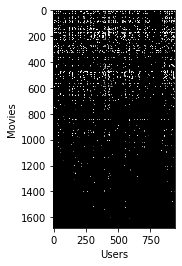

In [33]:
plt.imshow(Y,cmap='gray')
plt.xlabel('Users')
plt.ylabel('Movies');

In [34]:
print('Please enter the movie ratings(1-5 or 0 if not seen): \n')
userRatings=np.zeros((numMovies,1))

# Ask user ratings for set movies
indices=[1,98,7,12,55,64,66,69,183,225,355]
for index in indices:
    movie=movies.loc[index]
    try:
        question=f"{movie['Movie']} ({movie['Year']})"
        question=question.ljust(50)
        rating=float(input(question))
        if 1<=rating<=5:
            userRatings[int(index)-1]=rating
    except Exception as e:
        break

Please enter the movie ratings(1-5 or 0 if not seen): 

Toy Story (1995)                                  1
Silence of the Lambs, The (1991)                  2
Twelve Monkeys (1995)                             3
Usual Suspects, The (1995)                        3
Professional, The (1994)                          4
Shawshank Redemption, The (1994)                  5
While You Were Sleeping (1995)                    6
Forrest Gump (1994)                               7
Alien (1979)                                      8
101 Dalmatians (1996)                             9
Sphere (1998)                                     10


In [35]:
# Adding new user ratings 
Y=np.column_stack((userRatings,Y))
# Updating R with new user ratings
R=np.column_stack((np.zeros(numMovies),R))
indices=np.where(Y[:,0]!=0)[0]
R[indices,0]=1

In [36]:
# Normalize Ratings
Ymean=np.zeros((numMovies,1))
Ynorm=np.zeros(Y.shape)

for i in range(numMovies):
    idx=np.where(R[i,:]==1)
    Ymean[i]=Y[i,idx].mean()
    Ynorm[i,idx]=Y[i,idx]-Ymean[i]

Training Collaborative Filtering...


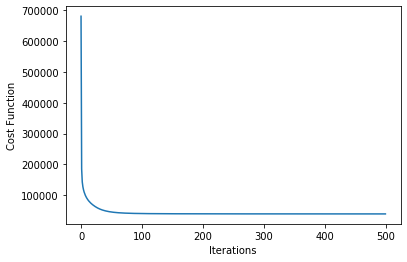

In [38]:
# Setting Initial Parameters
X=np.random.randn(numMovies,numFeatures)
theta=np.random.randn(numUsers,numFeatures)
initialParams=np.row_stack((X.reshape((-1,1)),theta.reshape((-1,1))))

# Setting Gradient descent options
lmbda=10
alpha=0.003
iterations=500

# Training Collaborative filtering
jHistory,params=regularizedGradientDescent(initialParams,Ynorm,R,numUsers,numMovies,numFeatures,lmbda,alpha,iterations)
# Unrolling the learned parameters into X and theta
X=params[:numMovies*numFeatures].reshape((numMovies,numFeatures))
theta=params[numMovies*numFeatures:].reshape((numUsers,numFeatures))

In [39]:
P=np.dot(X,theta.T)
userPrediction=P[:,0]+Ymean.reshape(-1)

In [40]:
df=movies.copy()
df['User Ratings']=userRatings
df[df['User Ratings']!=0]

,Movie,Year,User Ratings
ID,,,
1,Toy Story,1995,1.0
7,Twelve Monkeys,1995,3.0
12,"Usual Suspects, The",1995,3.0
55,"Professional, The",1994,4.0
64,"Shawshank Redemption, The",1994,5.0
98,"Silence of the Lambs, The",1991,2.0


In [41]:
limit=10
df=movies.copy()
df['Predicted Ratings']=userPrediction
df.sort_values(by=['Predicted Ratings'],ascending=False).head(limit)

,Movie,Year,Predicted Ratings
ID,,,
1201,Marlene Dietrich: Shadow and Light,1996,5.0
1189,Prefontaine,1997,5.0
1599,Someone Else's America,1995,5.0
1122,They Made Me a Criminal,1939,5.0
814,"Great Day in Harlem, A",1994,5.0
1293,Star Kid,1997,5.0
1536,Aiqing wansui,1994,5.0
1467,"Saint of Fort Washington, The",1993,5.0
1500,Santa with Muscles,1996,5.0
